# Lesson 1: Who is Exposed to Coastal Hazards in Puerto Rico?

## Contributors:
- Deborah Balk 
- Kytt MacManus
- Hieu Tran
- Camilla Greene
- Shemontee Chowdhury

## Language:
- Python/Jupyter Notebook

## Datasets:
- VIIRS Nighttime Lights
- LECZ
- NHGIS
- LiDAR SAR

## Areas of Interest (AOIs):
- Puerto Rico (PRI)

## Functions:
- Image segmentation
- Validation with SAR or LiDAR

# Overview

In this lesson, you will use the dataset delineating [Low Elevation Coastal Zones](https://sedac.ciesin.columbia.edu/data/set/lecz-low-elevation-coastal-zones) from the NASA Socioeconomic Data and Applications Center (SEDAC) website along with census data from the [US Census Bureau](https://www.census.gov/data.html). 

You will perform various preprocessing tasks to prepare the raw spatial data for analysis. These steps include exploring the dataset with visualizations and thematic mapping tools. You will then learn how to generate summary statistics based on combinations of these two layers, over two different time periods. 

You will learn how to perform numerous data manipulations, create statistical summaries of population-at-risk (and related housing characteristics), and examine a decade of change throughout this lesson.

# Learning Objectives

- Become familiar with Low Elevation Coastal Zones (LECZs) and explain their significance (as well as limitations) in assessing coastal hazard exposure.
- Access, integrate, explore, and use LECZ data from NASA SEDAC and demographic data from the US Census Bureau for Puerto Rico.
- Assess decadal changes (2010–2020) in population and housing characteristics in coastal versus non-coastal zones in Puerto Rico.
- Create regional and local scale maps and statistical figures of exposure and decadal change.
- Identify venues for sharing output (for example, discussion board associated with data, policy briefs, op-eds).

# Introduction

Low Elevation Coastal Zones (LECZs) have been defined globally, with population estimates for areas below 5m and 10m elevations (McGranahan et al. 2007, MacManus et al. 2021). In the continental U.S. (CONUS), 1 in 10 people live in the 10m LECZ, and studies highlight that urban residents, people of color, and older adults are disproportionately exposed. For instance, about 1 in 5 urban Black residents live in this zone (Tagtachian and Balk 2023, Hauer et al. 2020).

This is the sneak peak of what LECZ looks like:
![](https://raw.githubusercontent.com/hieutrn1205/TOPSTSCHOOL-disasters/refs/heads/main/lecz_notebook/image_&_chart/lecz_satellite.png)

You may wonder why studies of the “entire” US often restrict themselves to the CONUS? The simplest answer is limitations either data or computational power. For example, this happens because of incomplete coverage in one data set or another. Some US territories may not collect the full suite of census variables that are collected in CONUS. For example the detail on housing characteristics is limited in Guam, Northern Mariana Islands, US Virgin Islands and American Samoa, and the Census’ American Community Survey is not conducted in any of the territories, though Puerto Rico conducts its own Community Survey. In some other cases, data collected from satellites (such as SRTM) have variable accuracy toward polar regions [U.S Census Bureau](https://docs.google.com/document/d/1bKYopZoMLCD2djl2vc3pwNSKwGDk6TKRI79swefIvKY/edit?tab=t.0). 

Another possible reason for omission outside of CONUS could be computational challenges or limitations. For instance US territories are subject to different map projections, which implies the need for additional functions in processing algorithms to account for spatial variations and to unify spatial structures.


# Additional Resources

### “What is a Map Projection?”
Map projections have existed for thousands of years. They help map makers render the spherical surface of the Earth flat -- so it can be seen on a piece of paper or computer screen, and so that the unit of measure is uniform throughout the area of interest. As a result, map projections distort something -- area, shape, distance, direction -- to make this possible. 

Here are some resources to learn more about map projections:

A brief video explainer: https://www.youtube.com/watch?v=wlfLW1j05Dg

A brief guide from USGS: https://pubs.usgs.gov/gip/70047422/report.pdf

There are many resources to guide a new learner, so enjoy learning! 


### Required packages to run this lesson

```
impumspy
pandas
arcgis
zipfile
numpy
```

### Optional packages

```
glob
geopandas
earthaccess
```


In [1]:
from ipumspy import readers, ddi, IpumsApiClient, AggregateDataExtract, Dataset, DatasetMetadata
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from matplotlib.ticker import FuncFormatter
import arcgis
from arcgis.gis import GIS
from arcgis.map import Map
from arcgis.raster import Raster
from arcgis.features import GeoAccessor
from arcgis.map.renderers import (
    ClassBreaksRenderer,
    ClassBreakInfo,
    UniqueValueRenderer,
    UniqueValueInfo,
    SizeInfoVisualVariable,
)

from arcgis.map.symbols import SimpleLineSymbolEsriSLS, SimpleFillSymbolEsriSFS

import geopandas as gpd
import glob
from zipfile import ZipFile
import earthaccess as ea
import requests
import pprint
import re


c:\Users\hidey\anaconda3\envs\dev-env\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


This notebook is usable for the arcgis version of 2.4.0 or higher

In [2]:
# Check the arcgis version for mapping properly 
arcgis.__version__

'2.4.1'

## Using IPUMS API to pull U.S Census Data for Puerto Rico

In order to retrieve an IPUMS API Key. You will have to register for an account for IPUMS and request your [API Key]( https://account.ipums.org/api_keys).

After you requested your IPUMS API, store it in .env file.

In [2]:
#Load the IPUMS API key from the .env file

load_dotenv()

IPUMS_API_KEY = os.getenv("IPUMS_API_KEY")
ipums = IpumsApiClient(IPUMS_API_KEY)

### There are two ways of completing this lesson. Please read accordingly if the data are already downloaded or not

Run when you do not have data downloaded to your local drive. For first-time learner on this lesson

In [145]:
#Getting shapefile metadata in order to get the filename for downloading the shapefile in the below chunk
# This block will be returning the shapefile name of interest so that we can download it in the next block


for page in ipums.get_metadata_catalog("nhgis", metadata_type="shapefiles"):
    for shapefile in page["data"]:
        if shapefile["extent"] == "Puerto Rico":
            if shapefile["geographicLevel"] == "Block Group" and shapefile["year"] == "2010":
                print( "Name: " + shapefile["name"] + " | Year: " + shapefile["year"])

Name: 720_blck_grp_2010_tl2010 | Year: 2010
Name: 720_blck_grp_2010_tl2020 | Year: 2010


Getting data from 2010 and 2020 with the variables are Total Housing Units and Occupancy Status as H1 and H3 respectively. 

In [ ]:
#Submit extraction data to IPUMS portal

extract = AggregateDataExtract(
    collection="nhgis",
    description="Puerto Rico 2010-2020 vacancy",
    datasets=[
        Dataset(name="2010_SF1a", data_tables=["P12", "H3"], geog_levels=["blck_grp"]),
        Dataset(name = "2020_DHCa", data_tables = ["P12", "H3"], geog_levels = ["blck_grp"]),
    ],
    geographic_extents=["720"],
    shapefiles=["720_blck_grp_2020_tl2020"] #Get the shapefile name from above chunk
)

Download and extract the zip file 

In [5]:
#Submit the extract request
ipums.submit_extract(extract)
print(f"Extract ID: {extract.extract_id}")

#Wait for the extract to finish
ipums.wait_for_extract(extract)

#Download the extract
current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data") #Change to your storage location
ipums.download_extract(extract, download_dir=DOWNLOAD_DIR)

Extract ID: 21


In [47]:

current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data/county_data")

file_list = os.listdir(DOWNLOAD_DIR)
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]
shape_zip = [f for f in file_list if f.endswith('_shape.zip')]
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}" 
shapefile = f"{DOWNLOAD_DIR}/{shape_zip[0]}"
csv_data = ZipFile(csv).namelist()
shape_data = ZipFile(shapefile).namelist()

# Read zip data file in the extract
with ZipFile(shapefile) as outer_zip: # Shapefile data has 2 zipped layers
    with outer_zip.open(shape_data[0]) as inner_zip:
        with ZipFile(inner_zip) as inner:
            inner.extractall(DOWNLOAD_DIR) #Extract the shapefile into the data folder
            

### Run from here if you already downloaded the data from the above chunks

In [2]:

current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data/county_data") #County data

file_list = os.listdir(DOWNLOAD_DIR)
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]
shape_zip = [f for f in file_list if f.endswith('_shape.zip')]
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}" 
shapefile = f"{DOWNLOAD_DIR}/{shape_zip[0]}"
csv_data = ZipFile(csv).namelist()
shape_data = ZipFile(shapefile).namelist()

Read the csv file for 2010 and 2020 data 

In [4]:
# Check what index in the zipfile are csv files
# In this case, the first and the last file are the csv files and check the year for each csv file

csv_data

['nhgis0019_csv/nhgis0019_ds172_2010_county.csv',
 'nhgis0019_csv/nhgis0019_ds172_2010_county_codebook.txt',
 'nhgis0019_csv/nhgis0019_ds258_2020_county_codebook.txt',
 'nhgis0019_csv/nhgis0019_ds258_2020_county.csv']

In [3]:
#Read csv data

with ZipFile(csv) as z:
    with z.open(csv_data[-1]) as f: 
        df_2020 = pd.read_csv(f) #Load the 2020 data
    with z.open(csv_data[0]) as f:
        df_2010 = pd.read_csv(f) #Load the 2010 data

### Optional blocks (For experiment)

"I don't recommend to add a layer from the shapefile directly because the data is big and time consuming is high"

We can read the shapfile using the spatial enabled dataframe from arcgis api

But to add the shapefile layer to the webmap takes a while so this is just for reference

In [ ]:

county_shp = pd.DataFrame.spatial.from_featureclass(location = "./data/county_data/US_county_2020.shp", sr = 3857)
m1 = Map("Puerto Rico")
m1.content.add(county_shp)

Used Earthdata to download NASA published dataset to local

In [ ]:
#Login to the Earthdata
# Create a username and password in .env file where you stored IPUMS API key
auth = ea.login(strategy= "environment")

# Using earthaccess to search and find 

url = "https://cmr.earthdata.nasa.gov/search/collections?concept_id[]=C123456-LPDAAC_ECS"

query = ea.search_datasets(keyword = "LECZ")
for collection in query[:10]:
    pprint.pprint(collection.summary(), sort_dicts=True, indent=4)
    print('')  # Add a space between collections for readability

#Download the data through the Earthdata
Query = (
    ea.granule_query()
    .short_name("CIESIN_SEDAC_LECZ_URPLAEV3")
    .debug(True)
)

print(f"Granule hits: {Query.hits()}")

# Get the first 10 granules
granules = Query.get(10)

#Check if the granules are cloud hosted
granules[1].cloud_hosted
download_file = ea.download(granules[1], local_path="./data")

# Load data to the notebook

tiff = [f for f in file_list if f.endswith('-geotiff.zip')]

tiff_path = os.path.join(f"{DOWNLOAD_DIR}/{tiff[0]}")


with ZipFile(tiff_path) as z:
    z.extractall(DOWNLOAD_DIR)

### Start preprocessing the Census data downloaded from IPUMS API

To map the shapefile to the map, we have to publish the shapefile as feature layer on MapViewer on ArcGIS Online by adding layer from your shapefile zipped folder. This lesson is public facing so we already published the layers for the learners.

In [4]:
#Rename the columns the human readable names


# Get the layer from the published data

gis = GIS()
layer = gis.content.get("3132216944b249a08d13b1aa0ee6fda2").layers[0] # The layer of PR county 2020 published to the portal


sedf = layer.query(where = "STATEFP = '72'").sdf # Query the layer to get only the PR data


# The NHGIS codes are as follows in the documentation which is downloaded from the IPUMS API 

# Rename columns for dataframe 2020

'''    Table 1:     Sex by Age for Selected Age Categories
    Universe:    Total population
    Source code: P12
    NHGIS code:  U7S
        U7S001:      Total
        U7S002:      Male
        U7S003:      Male: Under 5 years
        U7S004:      Male: 5 to 9 years
        U7S005:      Male: 10 to 14 years
        U7S006:      Male: 15 to 17 years
        U7S007:      Male: 18 and 19 years
        U7S008:      Male: 20 years
        U7S009:      Male: 21 years
        U7S010:      Male: 22 to 24 years
        U7S011:      Male: 25 to 29 years
        U7S012:      Male: 30 to 34 years
        U7S013:      Male: 35 to 39 years
        U7S014:      Male: 40 to 44 years
        U7S015:      Male: 45 to 49 years
        U7S016:      Male: 50 to 54 years
        U7S017:      Male: 55 to 59 years
        U7S018:      Male: 60 and 61 years
        U7S019:      Male: 62 to 64 years
        U7S020:      Male: 65 and 66 years
        U7S021:      Male: 67 to 69 years
        U7S022:      Male: 70 to 74 years
        U7S023:      Male: 75 to 79 years
        U7S024:      Male: 80 to 84 years
        U7S025:      Male: 85 years and over
        U7S026:      Female
        U7S027:      Female: Under 5 years
        U7S028:      Female: 5 to 9 years
        U7S029:      Female: 10 to 14 years
        U7S030:      Female: 15 to 17 years
        U7S031:      Female: 18 and 19 years
        U7S032:      Female: 20 years
        U7S033:      Female: 21 years
        U7S034:      Female: 22 to 24 years
        U7S035:      Female: 25 to 29 years
        U7S036:      Female: 30 to 34 years
        U7S037:      Female: 35 to 39 years
        U7S038:      Female: 40 to 44 years
        U7S039:      Female: 45 to 49 years
        U7S040:      Female: 50 to 54 years
        U7S041:      Female: 55 to 59 years
        U7S042:      Female: 60 and 61 years
        U7S043:      Female: 62 to 64 years
        U7S044:      Female: 65 and 66 years
        U7S045:      Female: 67 to 69 years
        U7S046:      Female: 70 to 74 years
        U7S047:      Female: 75 to 79 years
        U7S048:      Female: 80 to 84 years
        U7S049:      Female: 85 years and over
 
    Table 2:     Occupancy Status
    Universe:    Housing units
    Source code: H3
    NHGIS code:  U9X
        U9X001:      Total
        U9X002:      Occupied
        U9X003:      Vacant
'''


rename_2020 = {
    "U7S001": "Total_Population",
    "U7S002": "Male",
    "U7S003": "Male: Under 5 years",
    "U7S004": "Male: 5 to 9 years",
    "U7S005":      "Male: 10 to 14 years",
    "U7S006":      "Male: 15 to 17 years",
    "U7S007":      "Male: 18 and 19 years",
    "U7S008":      "Male: 20 years",
    "U7S009":      "Male: 21 years",
    "U7S010":      "Male: 22 to 24 years",
    "U7S011":      "Male: 25 to 29 years",
    "U7S012":      "Male: 30 to 34 years",
    "U7S013":      "Male: 35 to 39 years",
    "U7S014":      "Male: 40 to 44 years",
    "U7S015":      "Male: 45 to 49 years",
    "U7S016":      "Male: 50 to 54 years",
    "U7S017":      "Male: 55 to 59 years",
    "U7S018":      "Male: 60 and 61 years",
    "U7S019":      "Male: 62 to 64 years",
    "U7S020":      "Male: 65 and 66 years",
    "U7S021":      "Male: 67 to 69 years",
    "U7S022":      "Male: 70 to 74 years",
    "U7S023":      "Male: 75 to 79 years",
    "U7S024":      "Male: 80 to 84 years",
    "U7S025":      "Male: 85 years and over",
    "U7S026":      "Female",
    "U7S027":      "Female: Under 5 years",
    "U7S028":      "Female: 5 to 9 years",
    "U7S029":      "Female: 10 to 14 years",
    "U7S030":      "Female: 15 to 17 years",
    "U7S031":      "Female: 18 and 19 years",
    "U7S032":      "Female: 20 years",
    "U7S033":      "Female: 21 years",
    "U7S034":      "Female: 22 to 24 years",
    "U7S035":      "Female: 25 to 29 years",
    "U7S036":      "Female: 30 to 34 years",
    "U7S037":      "Female: 35 to 39 years",
    "U7S038":      "Female: 40 to 44 years",
    "U7S039":      "Female: 45 to 49 years",
    "U7S040":      "Female: 50 to 54 years",
    "U7S041":      "Female: 55 to 59 years",
    "U7S042":      "Female: 60 and 61 years",
    "U7S043":      "Female: 62 to 64 years",
    "U7S044":      "Female: 65 and 66 years",
    "U7S045":      "Female: 67 to 69 years",
    "U7S046":      "Female: 70 to 74 years",
    "U7S047":      "Female: 75 to 79 years",
    "U7S048":      "Female: 80 to 84 years",
    "U7S049":      "Female: 85 years and over",
    "U9X001": "Total_Housing_Units",
    "U9X002": "Occupied",
    "U9X003": "Vacant"
}

#Rename columns for dataframe 2010
'''    Table 1:     Housing Units
    Universe:    Housing units
    Source code: H1
    NHGIS code:  IFC
        IFC001:      Total
 
    Table 2:     Occupancy Status
    Universe:    Housing units
    Source code: H3
    NHGIS code:  IFE
        IFE001:      Total
        IFE002:      Occupied
        IFE003:      Vacant'''

rename_2010 = {
    "H76001": "Total_Population",
    "H76002": "Male",
    "H76003": "Male: Under 5 years",
    "H76004": "Male: 5 to 9 years",
    "H76005":      "Male: 10 to 14 years",
    "H76006":      "Male: 15 to 17 years",
    "H76007":      "Male: 18 and 19 years",
    "H76008":      "Male: 20 years",
    "H76009":      "Male: 21 years",
    "H76010":      "Male: 22 to 24 years",
    "H76011":      "Male: 25 to 29 years",
    "H76012":      "Male: 30 to 34 years",
    "H76013":      "Male: 35 to 39 years",
    "H76014":      "Male: 40 to 44 years",
    "H76015":      "Male: 45 to 49 years",
    "H76016":      "Male: 50 to 54 years",
    "H76017":      "Male: 55 to 59 years",
    "H76018":      "Male: 60 and 61 years",
    "H76019":      "Male: 62 to 64 years",
    "H76020":      "Male: 65 and 66 years",
    "H76021":      "Male: 67 to 69 years",
    "H76022":      "Male: 70 to 74 years",
    "H76023":      "Male: 75 to 79 years",
    "H76024":      "Male: 80 to 84 years",
    "H76025":      "Male: 85 years and over",
    "H76026":      "Female",
    "H76027":      "Female: Under 5 years",
    "H76028":      "Female: 5 to 9 years",
    "H76029":      "Female: 10 to 14 years",
    "H76030":      "Female: 15 to 17 years",
    "H76031":      "Female: 18 and 19 years",
    "H76032":      "Female: 20 years",
    "H76033":      "Female: 21 years",
    "H76034":      "Female: 22 to 24 years",
    "H76035":      "Female: 25 to 29 years",
    "H76036":      "Female: 30 to 34 years",
    "H76037":      "Female: 35 to 39 years",
    "H76038":      "Female: 40 to 44 years",
    "H76039":      "Female: 45 to 49 years",
    "H76040":      "Female: 50 to 54 years",
    "H76041":      "Female: 55 to 59 years",
    "H76042":      "Female: 60 and 61 years",
    "H76043":      "Female: 62 to 64 years",
    "H76044":      "Female: 65 and 66 years",
    "H76045":      "Female: 67 to 69 years",
    "H76046":      "Female: 70 to 74 years",
    "H76047":      "Female: 75 to 79 years",
    "H76048":      "Female: 80 to 84 years",
    "H76049":      "Female: 85 years and over",
    "IFC001": "Total_Housing",
    "IFE001": "Total_Housing_Units",
    "IFE002": "Occupied",
    "IFE003": "Vacant"
}

df_2010.rename(columns = rename_2010, inplace = True)
df_2020.rename(columns = rename_2020, inplace = True)


# Get only columns of AGE/SEX and Housing 
joined_columns = list(df_2020.iloc[:5,59:].columns) + ["GISJOIN"]

#Merge 2010 df to 2020 df
df_2020_merged = df_2020.copy()

merged_df = df_2020_merged.merge(df_2010[["GISJOIN", "Total_Housing_Units", "Occupied", "Vacant"]], on = "GISJOIN", how = "inner", suffixes=("_2020", "_2010"))

#Merge the feature to the merged 2010-2020 df
pr_sedf = sedf.merge(merged_df, on = "GISJOIN", how = "inner")
pr_sedf["Total_Vacant_Change"] = pr_sedf["Vacant_2020"] - pr_sedf["Vacant_2010"]
pr_sedf["Total_Vacant_Percentile"] = pd.qcut(pr_sedf["Total_Vacant_Change"], 5, labels = range(1,6)) 

# Create std mean for the data
mean = pr_sedf["Total_Vacant_Change"].mean()
std = pr_sedf["Total_Vacant_Change"].std()


# Create a function to classify the data into standard deviations
def classify_std(value, mean, std):
    if value < mean - 2*std:
        return "< -2 Std Dev"
    elif mean - 2*std <= value < mean - std:
        return "-2 to -1 Std Dev"
    elif mean - std <= value < mean:
        return "-1 to 0 Std Dev"
    elif mean <= value < mean + std:
        return "0 to 1 Std Dev"
    elif mean + std <= value < mean + 2*std:
        return "1 to 2 Std Dev"
    elif mean + 2*std <= value:
        return "> 2 Std Dev"

pr_sedf["Total_Vacant_Change_Std"] = pr_sedf["Total_Vacant_Change"].apply(lambda x: classify_std(x, mean, std))

pr_sedf.head()

,FID,GISJOIN,STATEFP,COUNTYFP,COUNTYNS,GEOID_x,NAME_x,NAMELSAD,LSAD,CLASSFP,...,Female: 85 years and over,Total_Housing_Units_2020,Occupied_2020,Vacant_2020,Total_Housing_Units_2010,Occupied_2010,Vacant_2010,Total_Vacant_Change,Total_Vacant_Percentile,Total_Vacant_Change_Std
0,3144,G7200010,72,001,01804480,72001,Adjuntas,Adjuntas Municipio,13,H1,...,227,7911,6981,930,8125,6851,1274,-344,2,-1 to 0 Std Dev
1,3145,G7200030,72,003,01804481,72003,Aguada,Aguada Municipio,13,H1,...,430,17362,15062,2300,18258,15156,3102,-802,1,-2 to -1 Std Dev
2,3146,G7200050,72,005,01804482,72005,Aguadilla,Aguadilla Municipio,13,H1,...,836,27862,22951,4911,28430,23552,4878,33,4,0 to 1 Std Dev
3,3147,G7200070,72,007,01804483,72007,Aguas Buenas,Aguas Buenas Municipio,13,H1,...,331,10553,9424,1129,11490,10040,1450,-321,2,-1 to 0 Std Dev
4,3148,G7200090,72,009,01804484,72009,Aibonito,Aibonito Municipio,13,H1,...,376,10953,10077,876,10409,9367,1042,-166,2,-1 to 0 Std Dev


Search for the LECZ MERIT-DEM layer on ArcGIS Online's Living Atlas portal.

<Item title:"Low Elevation Coastal Zones derived from MERIT-DEM" type:Imagery Layer owner:NASA_Earthdata>
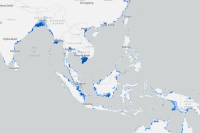

<Item title:"Global population living within 10m of sea level (2015)" type:Tiled Imagery Layer owner:dasbury_storymaps>
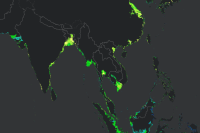

In [12]:
#Search for the LECZ layer in the ArcGIS Online

lecz = gis.content.search("Low Elevation Coastal Zones derived from MERIT-DEM", item_type="Imagery Layer")
for item in lecz:
    display(item)
lecz_layer = lecz[0] #Change 0 to 1 or vice versa to get the MERIT-DEM layer


Modify the legend's label and layer's title LECZ's published layer. You can reproduce the new WebMap with TOPSTSCHOOL's published LECZ layer by copying the id b08faa22bfec43308a0aa05a267ca26a. 

In [6]:
#Modify the title and the label of the LECZ layer

lecz_wm = gis.content.get("b08faa22bfec43308a0aa05a267ca26a")


## get the symbology definition from the original webmap
lecz_prop = lecz_wm.get_data()["operationalLayers"][0]["layerDefinition"]

## update the label classes
lecz_prop["drawingInfo"]["renderer"]["uniqueValueGroups"][0]["classes"][0]["label"] = "0 - 5m"
lecz_prop["drawingInfo"]["renderer"]["uniqueValueGroups"][0]["classes"][1]["label"] = "0 - 5m"
lecz_prop["drawingInfo"]["renderer"]["uniqueValueGroups"][0]["classes"][2]["label"] = "0 - 5m"

We're calssifying Vacant Decadal Change with Quantile Classification and see how it will interpret

In [7]:
#Unique Value Renderer


quantile_labels = ['Lowest 20%', '20-40%', '40-60%', '60-80%', 'Highest 20%']


symbol1 = SimpleFillSymbolEsriSFS(
    color = [26,150,65, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 1,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
symbol2 = SimpleFillSymbolEsriSFS(
    color = [166,217,106, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 1,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol3 = SimpleFillSymbolEsriSFS(
    color = [255,255,191, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 1,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol4 = SimpleFillSymbolEsriSFS(
    color = [253,174,97, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 1,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol5 = SimpleFillSymbolEsriSFS(
    color = [215,25,28, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 1,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
unique_value_infos = [
    UniqueValueInfo(
        value=1,
        label=quantile_labels[0],
        symbol=symbol1,
    ),
    UniqueValueInfo(
        value=2,
        label=quantile_labels[1],
        symbol=symbol2,
    ),
    UniqueValueInfo(
        value=3,
        label=quantile_labels[2],
        symbol=symbol3,
    ),
    UniqueValueInfo(
        value=4,
        label=quantile_labels[3],
        symbol=symbol4,
    ),
    UniqueValueInfo(
        value=5,
        label=quantile_labels[4],
        symbol=symbol5,
    )
]

pr_uvr = UniqueValueRenderer(
    type="uniqueValue",
    field1="Total_Vacant_Percentile",
    uniqueValueInfos=unique_value_infos,
)

#Labeling info

pr_labeling_info = [
      {
        "labelExpression": "[NAME_x]",
        "labelPlacement": "esriServerPolygonPlacementAlwaysHorizontal",
        "repeatLabel": True,
        "symbol": {
          "type": "esriTS",
          "color": [
            0,
            0,
            0,
            255
          ],
          "font": {
            "family": "Arial",
            "size": 12
          },
          "horizontalAlignment": "center",
          "kerning": True,
        },
      }
]

pr_options_dict = {
    "showLabels" : True,
    "layerDefinition" : {
        "drawingInfo" : {
            "labelingInfo" : pr_labeling_info,
            "renderer" : pr_uvr.dict(),
        }
    },
    "opacity" : 0.5,
    "title" : "Vacant Housing Units Decadal Change",
}

Start mapping with WebMap from AGOL Python API. Documentation is here for more infos: [ArcGIS API for Python](https://developers.arcgis.com/python-2-3/)

<Item title:"Low Elevation Coastal Zones derived from MERIT-DEM" type:Imagery Layer owner:NASA_Earthdata>
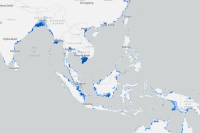

In [11]:
lecz

In [17]:
m = Map("Puerto Rico")
m.content.add(lecz_layer)
m

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [18]:
m.content.layers

[<ImageryLayer url:"https://gis.earthdata.nasa.gov/image/rest/services/lecz/lecz_urban_rural_population_land_area_estimates_v3/ImageServer">]

In [8]:
m1 = Map("Puerto Rico")
m1.content.add(pr_sedf, options = pr_options_dict)
m1.content.add(lecz, options={"opacity": 0.5})
## update the legend label for LECZ layer in Notebooks

m1.content.update_layer(
    index = 1, 
    options= {
        "title": "LECZ",
        "layerDefinition" : lecz_prop
    }
)
m1

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [13]:
m1.legend.enabled = True


It looks like Cabo Rojo has a little change after the hurricane Maria. But the real story can be misinterpreted by the current data classification.

Let's have a look at the bar chart for more details.

In [40]:
m1.content.layers

[<FeatureCollection>,
 <ImageryLayer url:"https://gis.earthdata.nasa.gov/image/rest/services/lecz/lecz_urban_rural_population_land_area_estimates_v3/ImageServer">]

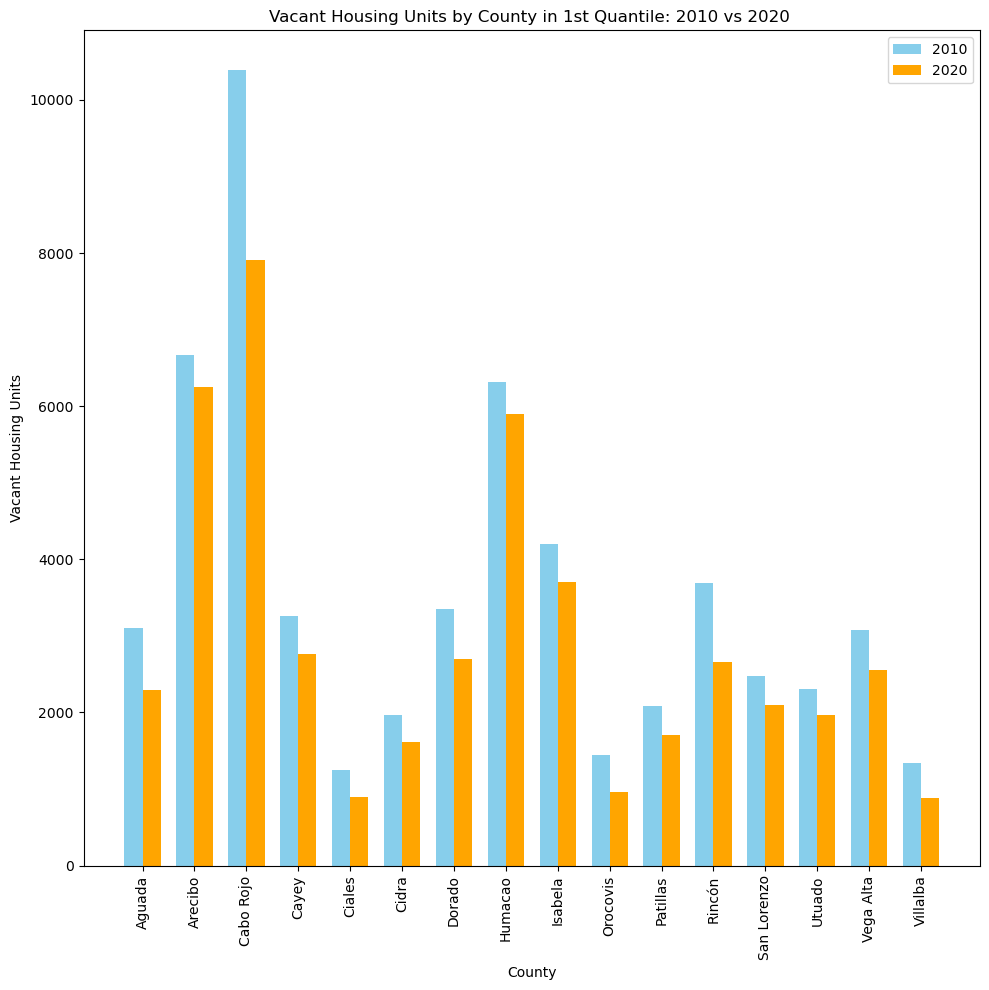

In [14]:

counties = pr_sedf[pr_sedf["Total_Vacant_Percentile"] == 1]["NAME_x"].tolist()
vacant_2010 = pr_sedf[pr_sedf["Total_Vacant_Percentile"] == 1].groupby("NAME_x")["Vacant_2010"].sum()
vacant_2020 = pr_sedf[pr_sedf["Total_Vacant_Percentile"] == 1].groupby("NAME_x")["Vacant_2020"].sum()
x = np.arange(len(counties))

width = 0.35 #the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, vacant_2010.values, width, label='2010', color='skyblue')
rects2 = ax.bar(x + width/2, vacant_2020.values, width, label='2020', color='orange')


ax.set_ylabel('Vacant Housing Units')
ax.set_xlabel('County')
ax.set_title('Vacant Housing Units by County in 1st Quantile: 2010 vs 2020 ')
ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

This histogram answers why the Cabo Rojo's Decadal Vacant Change is in the first quantile. There is only one county (frequency) that has less than -2000 value which is belong to Cabo Rojo. Therefore, Cabo Rojo is classified as lower quantile (1st quantile).

Text(0.5, 1.0, 'Vacant Housing Units Decadal Change 2010-2020')

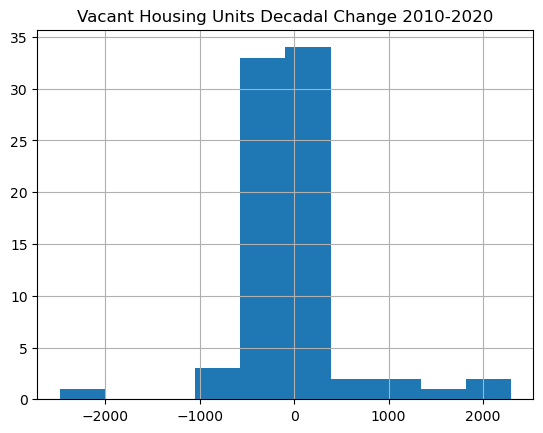

In [15]:
pr_sedf["Total_Vacant_Change"] .hist()
plt.title("Vacant Housing Units Decadal Change 2010-2020")

By looking more further into the histogram and difference bar chart between 2010 and 2020. We can have more confident that quantile classification did not do the right job at interpreation the data.

### Reclassify by Standard Deviation Classification

In [16]:
#Unique Value Renderer

# Label for the legend to display
labels = ['< -2Std Dev', '-2 to -1Std Dev', '-1 to 0Std Dev', '0 to 1Std Dev', '1 to 2Std Dev', '> 2Std Dev']

#Create the color for each unique value 
symbol1 = SimpleFillSymbolEsriSFS(
    color = [140,81,10, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.75,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
symbol2 = SimpleFillSymbolEsriSFS(
    color = [216,179,101, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.75,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol3 = SimpleFillSymbolEsriSFS(
    color = [246,232,195, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.75,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol4 = SimpleFillSymbolEsriSFS(
    color = [199,234,229, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.75,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol5 = SimpleFillSymbolEsriSFS(
    color = [90,180,172, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.75,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol6 = SimpleFillSymbolEsriSFS(
    color = [1,102,94, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.75,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

# Assign each symbol to a unique value
unique_value_infos = [
    UniqueValueInfo(
        value="< -2 Std Dev",
        label=labels[0],
        symbol=symbol1,
    ),
    UniqueValueInfo(
        value="-2 to -1 Std Dev",
        label=labels[1],
        symbol=symbol2,
    ),
    UniqueValueInfo(
        value="-1 to 0 Std Dev",
        label=labels[2],
        symbol=symbol3,
    ),
    UniqueValueInfo(
        value="0 to 1 Std Dev",
        label=labels[3],
        symbol=symbol4,
    ),
    UniqueValueInfo(
        value="1 to 2 Std Dev",
        label=labels[4],
        symbol=symbol5,
    ),
    UniqueValueInfo(
        value="> 2 Std Dev",
        label=labels[5],
        symbol=symbol6,
    )
]


# Create the Unique Value Renderer
std_uvr = UniqueValueRenderer(
    type="uniqueValue",
    field1="Total_Vacant_Change_Std",
    uniqueValueInfos=unique_value_infos,
)

#Labeling info

pr_labeling_info = [
      {
        "labelExpression": "[NAME_x]",
        "labelPlacement": "esriServerPolygonPlacementAlwaysHorizontal",
        "repeatLabel": True,
        "symbol": {
          "type": "esriTS",
          "color": [
            0,
            0,
            0,
            255
          ],
          "font": {
            "family": "Arial",
            "size": 12
          },
          "horizontalAlignment": "center",
          "kerning": True,
        },
      }
]


# Create the options dictionary for the layer
pr_options_dict = {
    "showLabels" : True,
    "layerDefinition" : {
        "drawingInfo" : {
            "labelingInfo" : pr_labeling_info,
            "renderer" : std_uvr.dict(),
        },
    },
    "opacity" : 0.5,
    "title" : "Vacant Housing Units Decadal Change",

}



In [17]:
m2 = Map("Puerto Rico")
m2.content.add(pr_sedf, options = pr_options_dict)
m2.content.add(lecz, options={"opacity": 0.5})


## update the WebMap in Notebooks
m2.content.update_layer(
    index = 1,  #LECZ layer is added as the second layer
    options= {
        "title": "LECZ",
        "layerDefinition" : lecz_prop
    }
)
m2

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [18]:
m2.legend.enabled = True

### Create an Age/Sex pyramid chart to get more insight of Puerto Rico's population

In [19]:
# Get only age columns 

new_df_columns = joined_columns[1:-4]
age_columns = new_df_columns[1:24]  # Extract age columns from the joined columns
new_age_columns = list()


# Extract the age categories from the age columns
for i in range(len(age_columns)):
    match_case = re.search(r'Male:\s*(.*)', age_columns[i])
    if match_case:
        new_age_columns.append(match_case.group(1))

# Create two lists to store percentage values
male_age_percentages = []
female_age_percentages = []

# Create a new DataFrame to hold the percentage values
pct_df = pr_sedf[joined_columns[0:-4]].copy()
pct_df.drop(columns= joined_columns[:-4], inplace=True)

# Calculate the percentage of each age group
for idx, col in enumerate(joined_columns[:-4]):
    pct_df[f"{col}_pct"] = pr_sedf[col] / pr_sedf["Total_Population"] * 100

# Drop the old age columns and keep only the percentage columns
pct_df.drop(columns=[col for col in pct_df.columns if not col.endswith("_pct")], inplace=True)

# Add the percentag values to the lists created above
for col in pct_df.columns:
    if col.startswith("Male:"):
        male_age_percentages.append(round(pct_df[col].mean(),2))
    elif col.startswith("Female:"):
        female_age_percentages.append(round(pct_df[col].mean(),2))

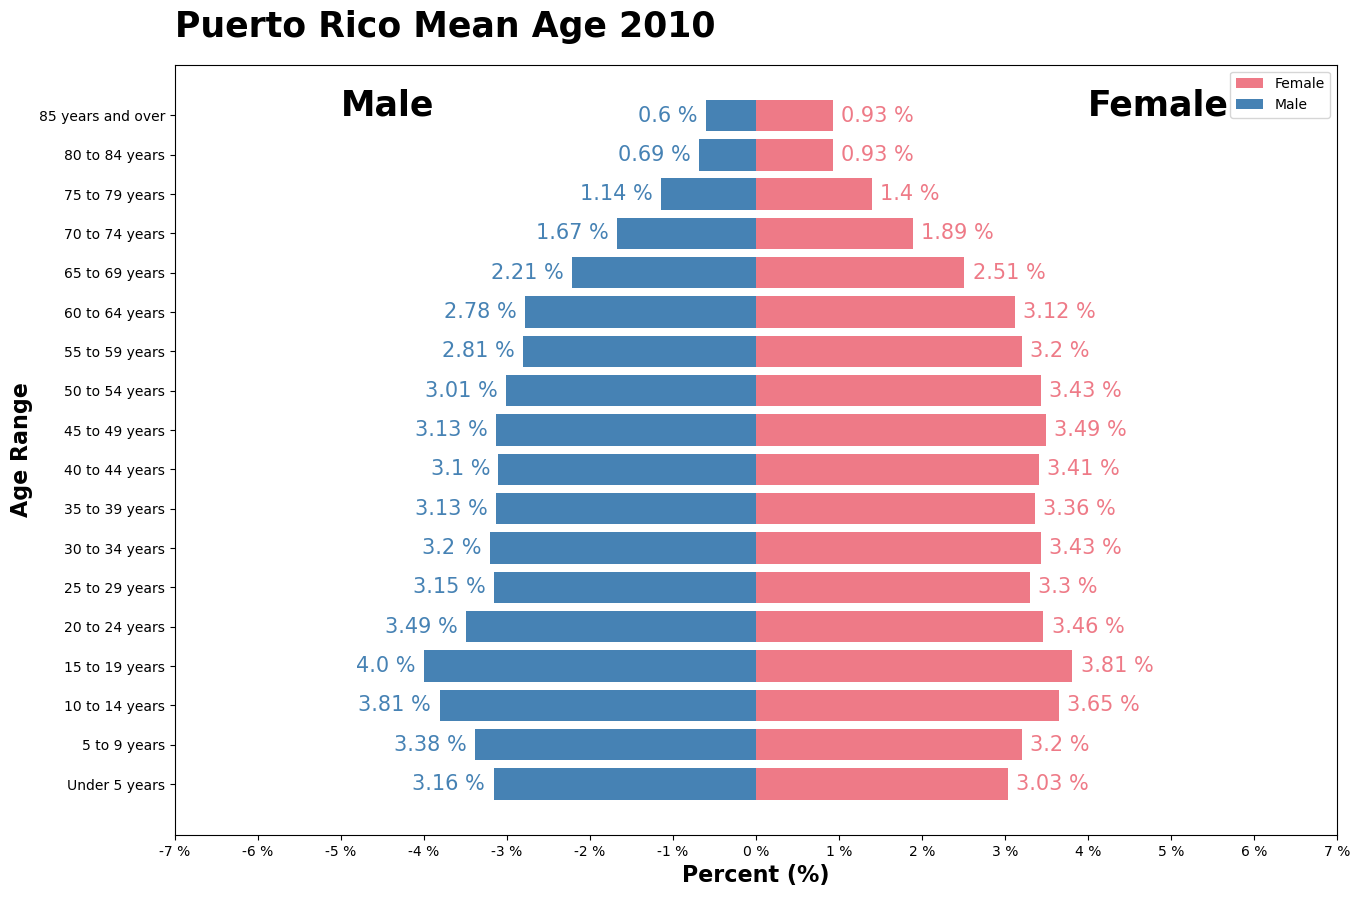

In [20]:
# Create a new DataFrame to hold the percentage values
pct_df = df_2010[joined_columns[0:-4]].copy()
# pct_df.drop(columns= joined_columns[:-4], inplace=True)

# Create two lists to store percentage values
male_age_percentages = []
female_age_percentages = []

# Calculate the percentage of each age group
for idx, col in enumerate(joined_columns[:-4]):
    pct_df[f"{col}_pct"] = pct_df[col] / pct_df["Total_Population"] * 100

# Drop the old age columns and keep only the percentage columns
pct_df.drop(columns=[col for col in pct_df.columns if not col.endswith("_pct")], inplace=True)

# Add the percentag values to the lists created above
for col in pct_df.columns:
    if col.startswith("Male:"):
        male_age_percentages.append(round(pct_df[col].mean(),2))
    elif col.startswith("Female:"):
        female_age_percentages.append(round(pct_df[col].mean(),2))


female_color = "#ee7a87"
male_color = "#4682b4"


population_df = pd.DataFrame({"Age": new_age_columns, "Male": male_age_percentages, "Female": female_age_percentages})

population = population_df.copy()

#Combine age groups from 15-17, 18-19 to 15-19

population.iloc[3, 0] = "15 to 19 years"
population.iloc[3, 1] = population.iloc[3, 1] + population.iloc[4, 1]
population.iloc[3, 2] = population.iloc[3, 2] + population.iloc[4, 2]
population = population.drop(4).reset_index(drop = True)  # Remove the 18-19 years row

#Combine age groups from 20, 21, 22-24 to 20-24

population.iloc[4, 0] = "20 to 24 years"
population.iloc[4, 1] = round(population.iloc[4, 1] + population.iloc[5, 1] + population.iloc[6, 1],2)
population.iloc[4, 2] = round(population.iloc[4, 2] + population.iloc[5, 2] + population.iloc[6, 2],2)
population = population.drop([5, 6]).reset_index(drop = True)  # Remove the 20, 21, 22-24 years rows

#Combine age groups from 60-61, 62-64 to 60-64
population.iloc[12, 0] = "60 to 64 years"
population.iloc[12, 1] = population.iloc[12, 1] + population.iloc[13, 1]
population.iloc[12, 2] = population.iloc[12, 2] + population.iloc[13, 2]
population = population.drop([13]).reset_index(drop = True)  # Remove the 62-64 years row

#Combine age groups from 65-66, 67-69 to 65-69
population.iloc[13, 0] = "65 to 69 years"
population.iloc[13, 1] = population.iloc[13, 1] + population.iloc[14, 1]
population.iloc[13, 2] = population.iloc[13, 2] + population.iloc[14, 2]
population = population.drop([14]).reset_index(drop = True)  # Remove the 67-69 years row

population["Female_Left"] = 0
population["Female_Width"] = population["Female"]

population["Male_Left"] = -population["Male"]
population["Male_Width"] = population["Male"]

population["Male"] = population["Male"].round(2)
population["Female"] = population["Female"].round(2)

population_df

fig = plt.figure(figsize=(15,10))

plt.barh(y=population["Age"], width=population["Female_Width"], color="#ee7a87", label="Female");
plt.barh(y=population["Age"], width=population["Male_Width"], left=population["Male_Left"],
         color="#4682b4", label="Male");

plt.text(-5, 17, "Male", fontsize=25, fontweight="bold");
plt.text(4, 17, "Female", fontsize=25, fontweight="bold");

for idx in range(len(population)):
    plt.text(x=population["Male_Left"][idx]-0.1, y=idx, s="{} %".format(population["Male"][idx]),
             ha="right", va="center",
             fontsize=15, color="#4682b4");
    plt.text(x=population["Female_Width"][idx]+0.1, y=idx, s="{} %".format(population["Female"][idx]),
             ha="left", va="center",
             fontsize=15, color="#ee7a87");

plt.xlim(-7,7);
plt.xticks(range(-7,8), ["{} %".format(i) for i in range(-7,8)]);

plt.legend(loc="best");

plt.xlabel("Percent (%)", fontsize=16, fontweight="bold")
plt.ylabel("Age Range", fontsize=16, fontweight="bold")
plt.title("Puerto Rico Mean Age 2010", loc="left", pad=20, fontsize=25, fontweight="bold");

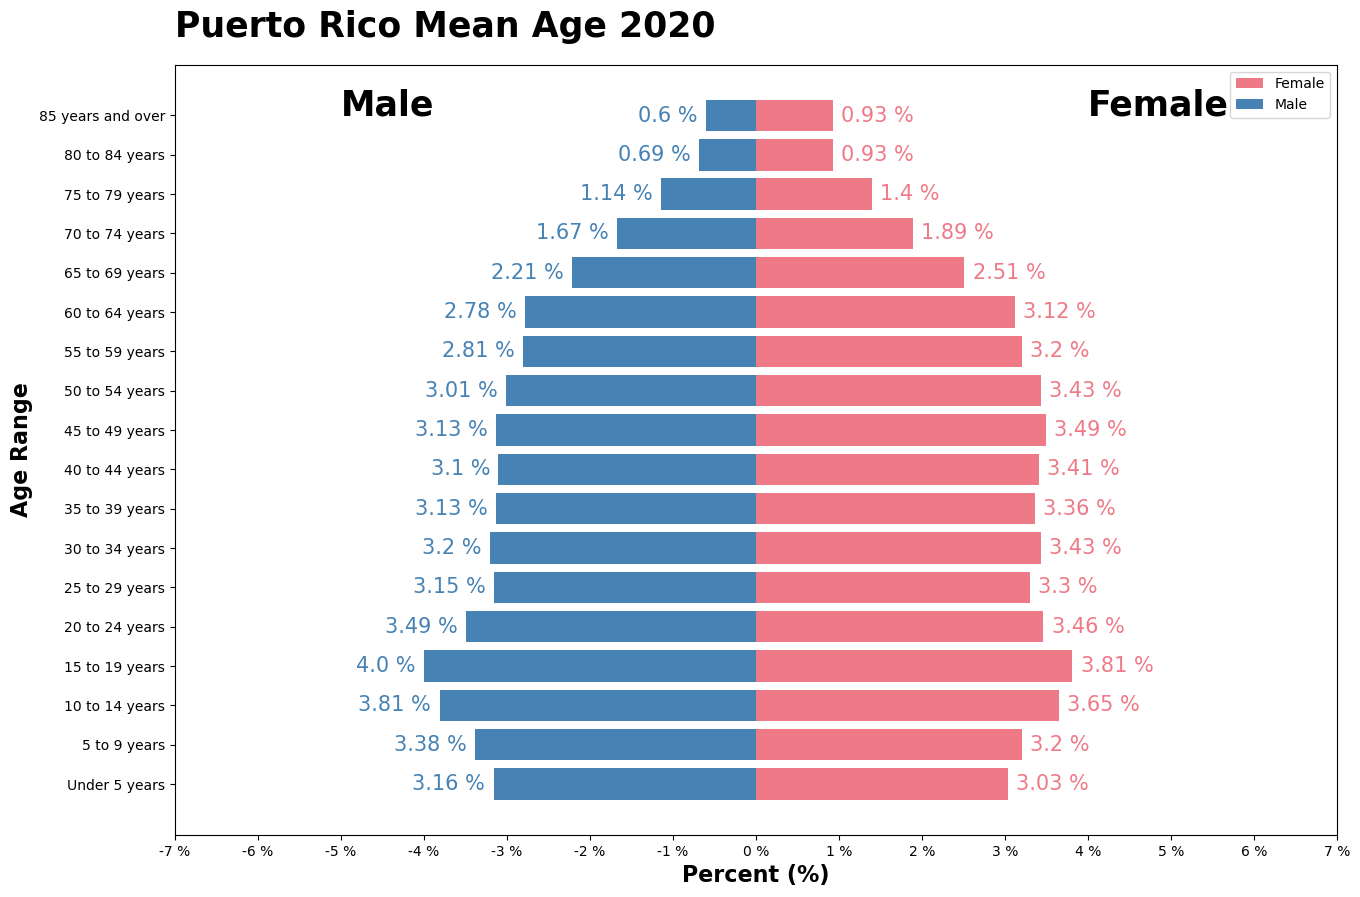

In [22]:
female_color = "#ee7a87"
male_color = "#4682b4"


population_df = pd.DataFrame({"Age": new_age_columns, "Male": male_age_percentages, "Female": female_age_percentages})

population = population_df.copy()

#Combine age groups from 15-17, 18-19 to 15-19

population.iloc[3, 0] = "15 to 19 years"
population.iloc[3, 1] = population.iloc[3, 1] + population.iloc[4, 1]
population.iloc[3, 2] = population.iloc[3, 2] + population.iloc[4, 2]
population = population.drop(4).reset_index(drop = True)  # Remove the 18-19 years row

#Combine age groups from 20, 21, 22-24 to 20-24

population.iloc[4, 0] = "20 to 24 years"
population.iloc[4, 1] = round(population.iloc[4, 1] + population.iloc[5, 1] + population.iloc[6, 1],2)
population.iloc[4, 2] = round(population.iloc[4, 2] + population.iloc[5, 2] + population.iloc[6, 2],2)
population = population.drop([5, 6]).reset_index(drop = True)  # Remove the 20, 21, 22-24 years rows

#Combine age groups from 60-61, 62-64 to 60-64
population.iloc[12, 0] = "60 to 64 years"
population.iloc[12, 1] = population.iloc[12, 1] + population.iloc[13, 1]
population.iloc[12, 2] = population.iloc[12, 2] + population.iloc[13, 2]
population = population.drop([13]).reset_index(drop = True)  # Remove the 62-64 years row

#Combine age groups from 65-66, 67-69 to 65-69
population.iloc[13, 0] = "65 to 69 years"
population.iloc[13, 1] = population.iloc[13, 1] + population.iloc[14, 1]
population.iloc[13, 2] = population.iloc[13, 2] + population.iloc[14, 2]
population = population.drop([14]).reset_index(drop = True)  # Remove the 67-69 years row

population["Female_Left"] = 0
population["Female_Width"] = population["Female"]

population["Male_Left"] = -population["Male"]
population["Male_Width"] = population["Male"]

population["Male"] = population["Male"].round(2)
population["Female"] = population["Female"].round(2)

population_df

fig = plt.figure(figsize=(15,10))

plt.barh(y=population["Age"], width=population["Female_Width"], color="#ee7a87", label="Female");
plt.barh(y=population["Age"], width=population["Male_Width"], left=population["Male_Left"],
         color="#4682b4", label="Male");

plt.text(-5, 17, "Male", fontsize=25, fontweight="bold");
plt.text(4, 17, "Female", fontsize=25, fontweight="bold");

for idx in range(len(population)):
    plt.text(x=population["Male_Left"][idx]-0.1, y=idx, s="{} %".format(population["Male"][idx]),
             ha="right", va="center",
             fontsize=15, color="#4682b4");
    plt.text(x=population["Female_Width"][idx]+0.1, y=idx, s="{} %".format(population["Female"][idx]),
             ha="left", va="center",
             fontsize=15, color="#ee7a87");

plt.xlim(-7,7);
plt.xticks(range(-7,8), ["{} %".format(i) for i in range(-7,8)]);

plt.legend(loc="best");

plt.xlabel("Percent (%)", fontsize=16, fontweight="bold")
plt.ylabel("Age Range", fontsize=16, fontweight="bold")
plt.title("Puerto Rico Mean Age 2020", loc="left", pad=20, fontsize=25, fontweight="bold");

Getting deeper to analyze what change in local scale. After looking at the broader resolution, now we move to the local resolution which is census tract level.

In [23]:
#Reading from zip file for block

current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data")

file_list = os.listdir(DOWNLOAD_DIR)
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]
shape_zip = [f for f in file_list if f.endswith('_shape.zip')]
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}" 
shapefile = f"{DOWNLOAD_DIR}/{shape_zip[1]}" #Block group shapefile
csv_data = ZipFile(csv).namelist()
shape_data = ZipFile(shapefile).namelist()

#Read csv data

with ZipFile(csv) as z:
    with z.open(csv_data[0]) as f: 
        blck_grp_2010 = pd.read_csv(f)
    with z.open(csv_data[1]) as f:
        blck_grp_2020 = pd.read_csv(f)

Using RegEx to remove the leading "0" in the county code to join them later on.

In [24]:
with ZipFile(shapefile) as outer_zip: # Shapefile data has 2 zipped layers
    with outer_zip.open(shape_data[0]) as inner_zip:
        with ZipFile(inner_zip) as inner:   
            inner.extractall(DOWNLOAD_DIR) #Extract the shapefile into the data folder

shp_df = pd.DataFrame.spatial.from_featureclass(location = "./data/PR_blck_grp_2020.shp", sr = 3857)
shp_df["COUNTYFP"] = shp_df["COUNTYFP"].str.replace(r"^0+", "", regex=True) #Remove leading zeros from the county codes
shp_df["COUNTYFP"] = shp_df["COUNTYFP"].astype(int) #Convert the county codes to int
shp_df["BLKGRPCE"] = shp_df["BLKGRPCE"].astype(int)

In [25]:
blck_grp_2010.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,H76043,H76044,H76045,H76046,H76047,H76048,H76049,IFE001,IFE002,IFE003
0,G72000109563001,2010,PR,9,0,Puerto Rico,72,Adjuntas Municipio,1,NaN,...,39,21,29,34,23,12,13,854,737,117
1,G72000109563002,2010,PR,9,0,Puerto Rico,72,Adjuntas Municipio,1,NaN,...,47,25,38,35,23,11,15,881,751,130
2,G72000109564001,2010,PR,9,0,Puerto Rico,72,Adjuntas Municipio,1,NaN,...,21,20,24,26,17,16,18,801,677,124
3,G72000109564002,2010,PR,9,0,Puerto Rico,72,Adjuntas Municipio,1,NaN,...,27,18,7,24,16,17,11,493,418,75
4,G72000109565001,2010,PR,9,0,Puerto Rico,72,Adjuntas Municipio,1,NaN,...,29,11,23,27,21,16,20,827,682,145


In [26]:
#Aggregate the data by block group and county for 2010 and 2020

blck_grp_2010.rename(columns = rename_2010, inplace = True)
blck_grp_2020.rename(columns = rename_2020, inplace = True)

#Merge the dataframes for 2010 and 2020 by block group and county

blck_grp_merged = shp_df.merge(blck_grp_2020, on = ["GISJOIN"], how = "inner", suffixes=("_2010", "_2020"))

# blck_grp_shp = shp_df.merge(blck_grp_merged[["GISJOIN", "COUNTY", "COUNTYA", "BLKGRPA", "Total_Housing_Units_2020", "Occupied_2020", "Vacant_2020", "Total_Housing_Units_2010", "Occupied_2010", "Vacant_2010"]], on = "GISJOIN", how = "right")

# blck_grp_merged["Total_Vacant_Change"] = blck_grp_merged["Vacant_2020"] - blck_grp_merged["Vacant_2010"]


# #Doing the EDA
blck_grp_merged.isna().sum()   #Check for missing values


GISJOIN                      0
STATEFP                      0
COUNTYFP                     0
TRACTCE                      0
BLKGRPCE                     0
                            ..
Female: 80 to 84 years       0
Female: 85 years and over    0
Total_Housing_Units          0
Occupied                     0
Vacant                       0
Length: 126, dtype: int64

In [27]:
# Create a dictionary with TRACTA as the primary key and BLKGRPA as secondary keys
tract_dict_2010 = {}


for _, row in blck_grp_2010.iterrows():
    tracta = row["TRACTA"]
    blkgrpa = row["BLKGRPA"]
    values = row.drop(["TRACTA", "BLKGRPA"]).to_dict()
    
    if tracta not in tract_dict_2010:
        tract_dict_2010[tracta] = {}
    
    tract_dict_2010[tracta][blkgrpa] = values


In [28]:
blck_grp_merged["Vacant_2010"] = 0 #Create a new column for the 2010 vacant housing units
blck_grp_merged["TRACTCE"] = blck_grp_merged["TRACTCE"].astype(int) 

for i in range(len(blck_grp_merged)):
    if blck_grp_merged["TRACTCE"][i] in tract_dict_2010:
        tract = blck_grp_merged["TRACTCE"][i]
        if blck_grp_merged["BLKGRPCE"][i] in tract_dict_2010[tract]:
            blk_grp = blck_grp_merged["BLKGRPCE"][i]
            blck_grp_merged["Vacant_2010"][i] = tract_dict_2010[tract][blk_grp]["Vacant"]

C:\Users\hidey\AppData\Local\Temp\ipykernel_17848\3970985759.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blck_grp_merged["Vacant_2010"][i] = tract_dict_2010[tract][blk_grp]["Vacant"]


In [29]:
# Create std mean for the data
blck_grp_merged["Total_Vacant_Change"] = blck_grp_merged["Vacant"] - blck_grp_merged["Vacant_2010"]


mean = blck_grp_merged["Total_Vacant_Change"].mean()
std = blck_grp_merged["Total_Vacant_Change"].std()


blck_grp_merged["Total_Vacant_Change_Std"] = blck_grp_merged["Total_Vacant_Change"].apply(lambda x: classify_std(x, mean, std))

In [30]:
# Get only age columns 

county = "Cabo Rojo" #Change the county name as desired

county_filter = blck_grp_merged[blck_grp_merged["COUNTY"] == f"{county} Municipio"]

new_df_columns = joined_columns[1:-4]
age_columns = new_df_columns[1:24]  # Extract age columns from the joined columns
new_age_columns = list()


# Extract the age categories from the age columns
for i in range(len(age_columns)):
    match_case = re.search(r'Male:\s*(.*)', age_columns[i])
    if match_case:
        new_age_columns.append(match_case.group(1))

# Create two lists to store percentage values
male_age_percentages = []
female_age_percentages = []

# Create a new DataFrame to hold the percentage values
county_pct_df = county_filter[joined_columns[0:-4]].copy()
county_pct_df.drop(columns= joined_columns[:-4], inplace=True)

# Calculate the percentage of each age group
for idx, col in enumerate(joined_columns[:-4]):
    county_pct_df[col] = 0
    county_pct_df[f"{col}_pct"] = county_filter[col] / county_filter["Total_Population"] * 100

# Drop the old age columns and keep only the percentage columns
county_pct_df.drop(columns=[col for col in county_pct_df.columns if not col.endswith("_pct")], inplace=True)

# Add the percentag values to the lists created above
for col in county_pct_df.columns:
    if col.startswith("Male:"):
        male_age_percentages.append(round(county_pct_df[col].mean(),2))
    elif col.startswith("Female:"):
        female_age_percentages.append(round(county_pct_df[col].mean(),2))

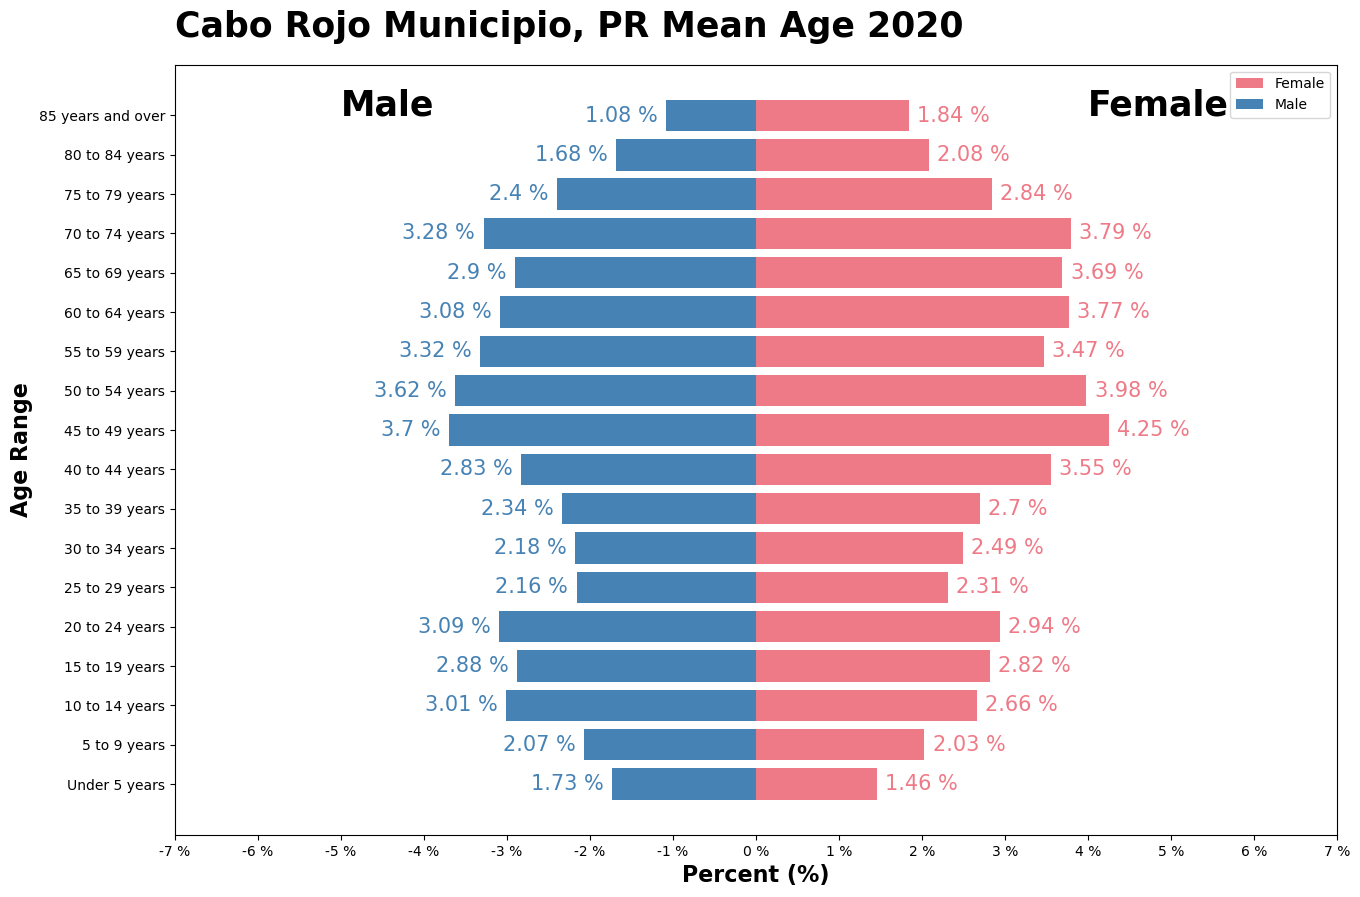

In [31]:
female_color = "#ee7a87"
male_color = "#4682b4"


population_df = pd.DataFrame({"Age": new_age_columns, "Male": male_age_percentages, "Female": female_age_percentages})

population = population_df.copy()

#Combine age groups from 15-17, 18-19 to 15-19

population.iloc[3, 0] = "15 to 19 years"
population.iloc[3, 1] = population.iloc[3, 1] + population.iloc[4, 1]
population.iloc[3, 2] = population.iloc[3, 2] + population.iloc[4, 2]
population = population.drop(4).reset_index(drop = True)  # Remove the 18-19 years row

#Combine age groups from 20, 21, 22-24 to 20-24

population.iloc[4, 0] = "20 to 24 years"
population.iloc[4, 1] = round(population.iloc[4, 1] + population.iloc[5, 1] + population.iloc[6, 1],2)
population.iloc[4, 2] = round(population.iloc[4, 2] + population.iloc[5, 2] + population.iloc[6, 2],2)
population = population.drop([5, 6]).reset_index(drop = True)  # Remove the 20, 21, 22-24 years rows

#Combine age groups from 60-61, 62-64 to 60-64
population.iloc[12, 0] = "60 to 64 years"
population.iloc[12, 1] = population.iloc[12, 1] + population.iloc[13, 1]
population.iloc[12, 2] = population.iloc[12, 2] + population.iloc[13, 2]
population = population.drop([13]).reset_index(drop = True)  # Remove the 62-64 years row

#Combine age groups from 65-66, 67-69 to 65-69
population.iloc[13, 0] = "65 to 69 years"
population.iloc[13, 1] = population.iloc[13, 1] + population.iloc[14, 1]
population.iloc[13, 2] = population.iloc[13, 2] + population.iloc[14, 2]
population = population.drop([14]).reset_index(drop = True)  # Remove the 67-69 years row

population["Male"] = population["Male"].round(2)
population["Female"] = population["Female"].round(2)

population["Female_Left"] = 0
population["Female_Width"] = population["Female"]

population["Male_Left"] = -population["Male"]
population["Male_Width"] = population["Male"]



fig = plt.figure(figsize=(15,10))

plt.barh(y=population["Age"], width=population["Female_Width"], color="#ee7a87", label="Female");
plt.barh(y=population["Age"], width=population["Male_Width"], left=population["Male_Left"],
         color="#4682b4", label="Male");

plt.text(-5, 17, "Male", fontsize=25, fontweight="bold");
plt.text(4, 17, "Female", fontsize=25, fontweight="bold");

for idx in range(len(population)):
    plt.text(x=population["Male_Left"][idx]-0.1, y=idx, s="{} %".format(population["Male"][idx]),
             ha="right", va="center",
             fontsize=15, color="#4682b4");
    plt.text(x=population["Female_Width"][idx]+0.1, y=idx, s="{} %".format(population["Female"][idx]),
             ha="left", va="center",
             fontsize=15, color="#ee7a87");

plt.xlim(-7,7);
plt.xticks(range(-7,8), ["{} %".format(i) for i in range(-7,8)]);

plt.legend(loc="best");

plt.xlabel("Percent (%)", fontsize=16, fontweight="bold")
plt.ylabel("Age Range", fontsize=16, fontweight="bold")
plt.title(f"{county} Municipio, PR Mean Age 2020", loc="left", pad=20, fontsize=25, fontweight="bold");

### Create the layerDefinition for Population layer.

We are using the same classification as the previous map which is Standard Deiviation Classification for accurate interpretation.

In [32]:
#Unique Value Renderer


labels = ['< -2Std Dev', '-2 to -1Std Dev', '-1 to 0Std Dev', '0 to 1Std Dev', '1 to 2Std Dev', '> 2Std Dev']


symbol1 = SimpleFillSymbolEsriSFS(
    color = [140,81,10, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
symbol2 = SimpleFillSymbolEsriSFS(
    color = [216,179,101, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol3 = SimpleFillSymbolEsriSFS(
    color = [246,232,195, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol4 = SimpleFillSymbolEsriSFS(
    color = [199,234,229, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol5 = SimpleFillSymbolEsriSFS(
    color = [90,180,172, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol6 = SimpleFillSymbolEsriSFS(
    color = [1,102,94, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
unique_value_infos = [
    UniqueValueInfo(
        value="< -2 Std Dev",
        label=labels[0],
        symbol=symbol1,
    ),
    UniqueValueInfo(
        value="-2 to -1 Std Dev",
        label=labels[1],
        symbol=symbol2,
    ),
    UniqueValueInfo(
        value="-1 to 0 Std Dev",
        label=labels[2],
        symbol=symbol3,
    ),
    UniqueValueInfo(
        value="0 to 1 Std Dev",
        label=labels[3],
        symbol=symbol4,
    ),
    UniqueValueInfo(
        value="1 to 2 Std Dev",
        label=labels[4],
        symbol=symbol5,
    ),
    UniqueValueInfo(
        value="> 2 Std Dev",
        label=labels[5],
        symbol=symbol6,
    )
]

tract_uvr = UniqueValueRenderer(
    type="uniqueValue",
    field1="Total_Vacant_Change_Std",
    uniqueValueInfos=unique_value_infos,
)

#Labeling info

tract_labeling_info = [
      {
        "labelExpression": "[COUNTY]",
        "labelPlacement": "esriServerPolygonPlacementAlwaysHorizontal",
        # "repeatLabel": False,
        "symbol": {
          "type": "esriTS",
          "color": [
            0,
            0,
            0,
            255
          ],
          "font": {
            "family": "Arial",
            "size": 12
          },
          "horizontalAlignment": "center",
          "kerning": True,
        },
      }
]

tract_options_dict = {
    "showLabels" : True,
    "layerDefinition" : {
        "drawingInfo" : {
            # "labelingInfo" : tract_labeling_info,
            "renderer" : std_uvr.dict(),
        },
    },
    "opacity" : 0.5,
    "title" : "Vacant Housing Units Decadal Change",
}



In [33]:
m3 = Map(f"{county}, Puerto Rico")
m3.content.add(county_filter, options = tract_options_dict)
m3.content.add(lecz, options={"opacity": 0.5})


# update the WebMap in Notebooks
m3.content.update_layer(
    index = 1, 
    options= {
        "title": "LECZ",
        "layerDefinition" : lecz_prop
    }
)   
m3

c:\Users\hidey\anaconda3\envs\dev-env\Lib\site-packages\arcgis\features\geo\_accessor.py:1602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data[col] = array


Map(center=[2040257.9003723264, -7479085.476476418], extent={'xmin': -7492555.134862403, 'ymin': 2026098.05672…

In [34]:
m3.legend.enabled = True

### How much developed land and population are exposed to LECZ?

For this analysis, we'll use VIIRS-Black Marble product from NASA to estimate how much developed land and population are exposed to the LECZ area.

But first of all, let's have a look at the historical data from the tragedy of Hurricane Maria which crossed Puerto Rico in September 2017.


This is the layer of pre-tragedy in Puerto Rico's nighttime light (Data from 2017 and before):
![](https://raw.githubusercontent.com/hieutrn1205/TOPSTSCHOOL-disasters/refs/heads/main/lecz_notebook/image_%26_chart/pre_hurricane.jpg)

This is the layer of post-tragedy (September - November 2017):
![](https://raw.githubusercontent.com/hieutrn1205/TOPSTSCHOOL-disasters/refs/heads/main/lecz_notebook/image_%26_chart/after_hurricane_sep_to_nov.jpg)


With these two layer of nighttime light from two different date range. We can estimate how it was destructive to Puerto Rico and the people living on it. There were some major cities went completely light out.


### Take a look at the same development indicator layer currently at PR.

<Item title:"VIIRS Nighttime Lights Monthly Cloud-Free Composite" type:Imagery Layer owner:esri_imagery>
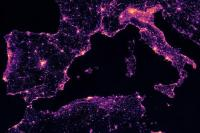

<Item title:"Nighttime Light on Oahu, Hawaii" type:Map Image Layer owner:jennifer_urmston@fws.gov_fws>
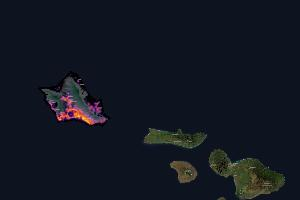

<Item title:"Wilder Northumberland Light Pollution DNB Polygon" type:Feature Layer Collection owner:efrith_wildlifetrusts>
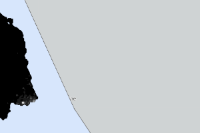

<Item title:"Day Night Band Imagery (VIIRS) for Hurricane Dorian (mosaic)" type:Imagery Layer owner:gwlayne_NASA>
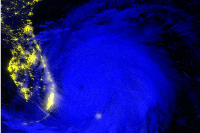

<Item title:"VIIRS Nighttime Lights" type:Web Map owner:kar.harutyunyan_YSU>
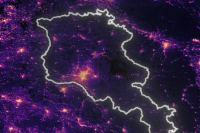

In [35]:
viirs = gis.content.search("VIIRS Nighttime Lights")

for item in viirs[:5]:
    display(item)

viirs_layer = viirs[0]  # Assuming the first item is the one you want

In [37]:
nighttime = Map("Puerto Rico")
nighttime.content.add(viirs_layer, options={"opacity": 0.65})
nighttime.content.add(pr_sedf, options = pr_options_dict)
nighttime.content.add(lecz, options={"opacity": 0.5})

In [38]:
nighttime

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [39]:
nighttime.legend.enabled = True

In this lesson, using the same types of inputs (population counts from other attributes from direct downloads of census data), LECZ data (based on MERIT DEM) and nighttime light by VIIRS dataset, you will learn how to construct estimates of populations (by different demographic or housing characteristics) living, and developed area, in low elevation coastal areas 10m contiguous to sea coast. State-level, county-level, tract census level summaries can be generated.

As you do this module, keep in mind:
- Low-elevation coastal zones are different from tropical storm-related hazards. 
- There is no unified data set on the full extent of tropical storms or future storm risks.  
    - For this reason, estimates that speak to a range of possibilities (from the LECZ only to the entire territory) are important for policy and planning purposes. 
- This analysis can serve as a starting point but has limitations on inference from our findings: changes over time are just that but causes that underlie those changes cannot be ascribed by this analysis. 


### In this lesson, you learned...

- Pulling Census data directly from IPUMS API 
- Reading and preprocessing the downloaded data
- Getting and modifying public WebMap from ArcGIS Online Python API
- Creating the interactive maps with geospatial data (Spatial Enabled Dataframe) from CSV data
- Performing an analysis with various chart types (bar, histogram, pyramid)
- Estimating the population based on how many percentages of LECZ layer and VIIRS layer overlapped with population layer
